# OTPless Signup Funnel & Retention Analysis

This notebook analyzes the user signup funnel and retention patterns for OTPless, a passwordless authentication platform.
All data is simulated but mirrors realistic product analytics.  
**Objectives:**
- Identify where users drop off during signup
- Understand post-signup retention (cohorts)
- Compare behavior by signup source (Web vs Mobile)
- Recommend improvements for onboarding and activation
.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

We load and preview the event log data to check for completeness and understand its structure.


In [2]:
df = pd.read_csv('sample_events_retention_fixed.csv', parse_dates=['signup_date', 'step_timestamp', 'activity_date', 'cohort_date'])
df.head()

,user_id,signup_date,signup_source,step_name,step_timestamp,activity_date,event_type,cohort_date,days_since_signup,is_active
0,1,2023-07-30,Web,landing_page,2023-07-30 17:03:00,2023-07-30,signup,2023-07-30,0,0
1,1,2023-07-30,Web,signup_start,2023-07-30 17:35:00,2023-07-30,signup,2023-07-30,0,0
2,1,2023-07-30,Web,otp_requested,2023-07-30 18:00:00,2023-07-30,otp,2023-07-30,0,0
3,1,2023-07-30,Web,otp_verified,2023-07-30 18:31:00,2023-07-30,otp,2023-07-30,0,0
4,1,2023-07-30,Web,account_created,2023-07-30 19:05:00,2023-07-30,create_account,2023-07-30,0,1


## Data Overview

A quick summary of users, events, sources, and missing data.


In [3]:
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("Unique users:", df['user_id'].nunique())
df['step_name'].value_counts()

Rows: 510
Columns: ['user_id', 'signup_date', 'signup_source', 'step_name', 'step_timestamp', 'activity_date', 'event_type', 'cohort_date', 'days_since_signup', 'is_active']
Unique users: 100


step_name
landing_page       100
signup_start        96
otp_requested       89
login               82
otp_verified        76
account_created     67
Name: count, dtype: int64

## Signup Funnel Drop-off

We'll count how many users reach each step of the signup funnel, and visualize the drop-off at each stage.


In [4]:
funnel_steps = ['landing_page', 'signup_start', 'otp_requested', 'otp_verified', 'account_created']
funnel = []
total_users = df['user_id'].nunique()
for step in funnel_steps:
    users_at_step = df[df['step_name'] == step]['user_id'].nunique()
    funnel.append({'step': step, 'users': users_at_step, 'pct_total': users_at_step / total_users * 100})

funnel_df = pd.DataFrame(funnel)
funnel_df

,step,users,pct_total
0,landing_page,100,100.0
1,signup_start,96,96.0
2,otp_requested,89,89.0
3,otp_verified,76,76.0
4,account_created,67,67.0


### Funnel Chart

We can see the largest drop-off happens at the OTP verification step. This is a key point to optimize.


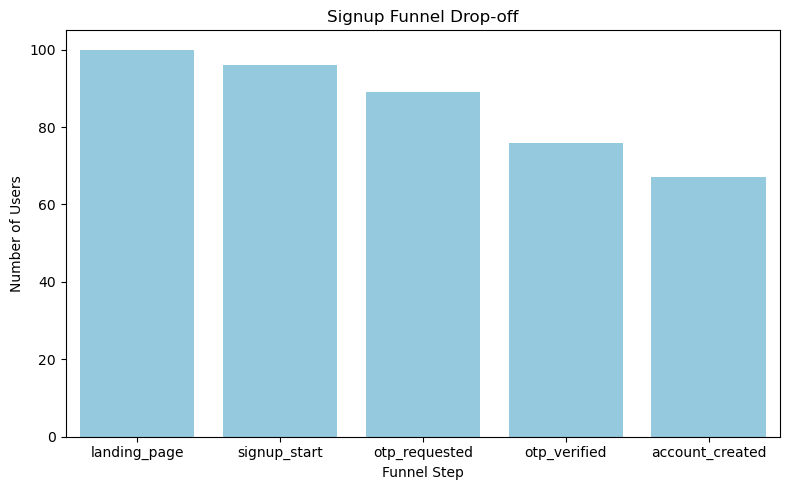

In [5]:
plt.figure(figsize=(8,5))
sns.barplot(x='step', y='users', data=funnel_df, color='skyblue')
plt.title('Signup Funnel Drop-off')
plt.ylabel('Number of Users')
plt.xlabel('Funnel Step')
plt.tight_layout()
plt.show()

## Conversion Comparison: Web vs Mobile

Let's see if signup completion differs for Web vs Mobile users.


signup_source
Mobile    0.709091
Web       0.622222
Name: user_id, dtype: float64


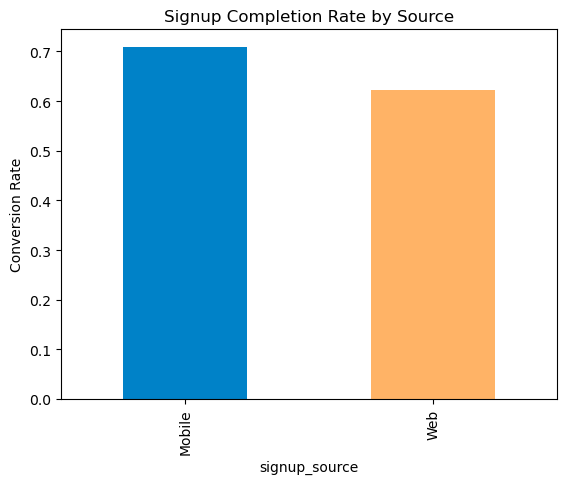

In [13]:
conversion_by_source = df[df['step_name'] == 'account_created'].groupby('signup_source')['user_id'].nunique() / \
                       df.groupby('signup_source')['user_id'].nunique()
print(conversion_by_source)
conversion_by_source.plot(kind='bar', color=['#0082c8','#ffb366'])
plt.title('Signup Completion Rate by Source')
plt.ylabel('Conversion Rate')
plt.show()

## Retention Cohort Analysis

Let's measure how many users come back and log in again after signup, grouped by signup date (cohort).


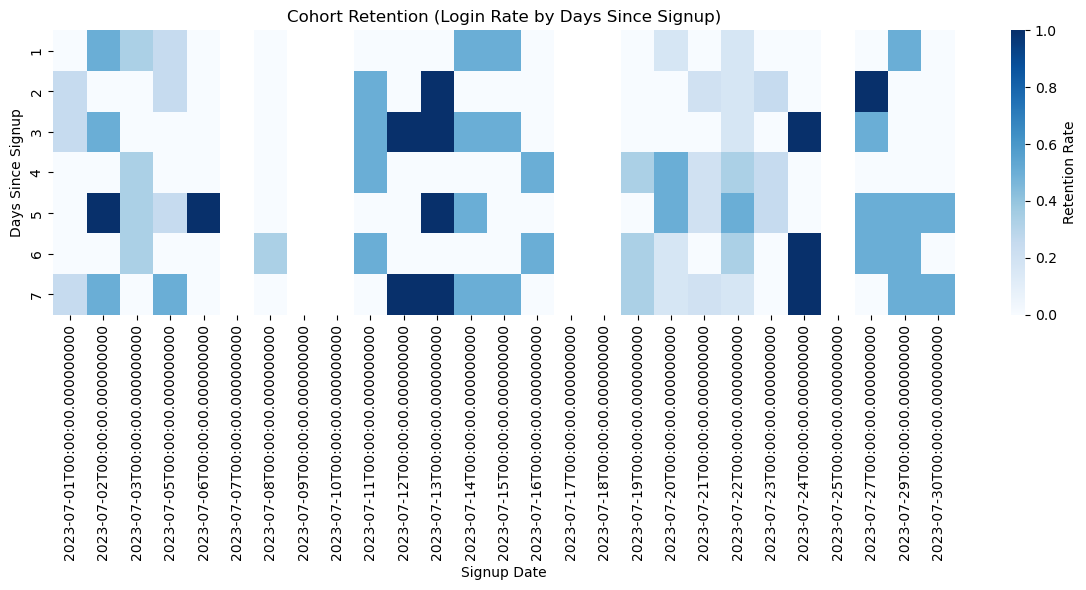

In [14]:
logins = df[df['step_name'] == 'login']
signup = df[df['step_name'] == 'account_created'][['user_id', 'signup_date']]
retention = logins.merge(signup, on='user_id', suffixes=('', '_signup'))
retention['step_timestamp'] = pd.to_datetime(retention['step_timestamp'])
retention['signup_date'] = pd.to_datetime(retention['signup_date'])
retention['days_since_signup'] = (retention['step_timestamp'] - retention['signup_date']).dt.days

cohort_sizes = signup.groupby('signup_date').size()
retention_pivot = retention.groupby(['signup_date', 'days_since_signup'])['user_id'].nunique().unstack(fill_value=0)
retention_rate = retention_pivot.divide(cohort_sizes, axis=0)
plt.figure(figsize=(12,6))
sns.heatmap(retention_rate.T, cmap='Blues', cbar_kws={'label': 'Retention Rate'})
plt.title('Cohort Retention (Login Rate by Days Since Signup)')
plt.xlabel('Signup Date')
plt.ylabel('Days Since Signup')
plt.tight_layout()
plt.show()

## Daily Active Users (DAU)

This shows the daily number of unique users returning to the platform.


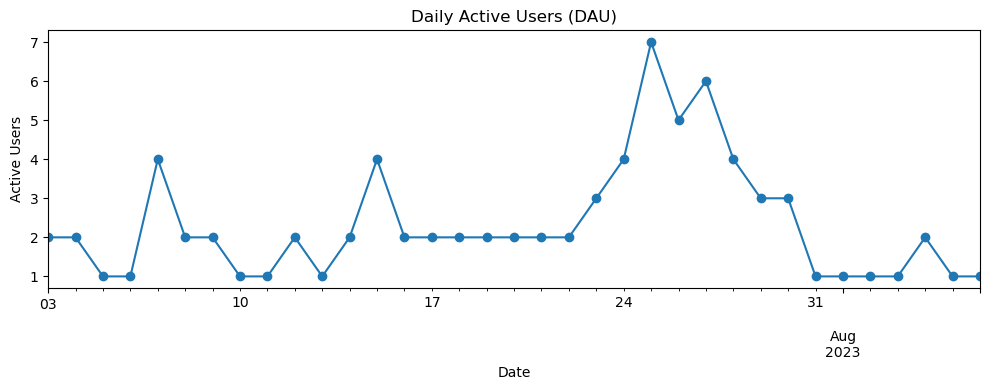

In [11]:
dau = df[df['step_name'] == 'login'].groupby('activity_date')['user_id'].nunique()
plt.figure(figsize=(10,4))
dau.plot(marker='o')
plt.title('Daily Active Users (DAU)')
plt.xlabel('Date')
plt.ylabel('Active Users')
plt.tight_layout()
plt.show()

## Churn Curve

This shows the percentage of users who are still active X days after signup (retention curve).


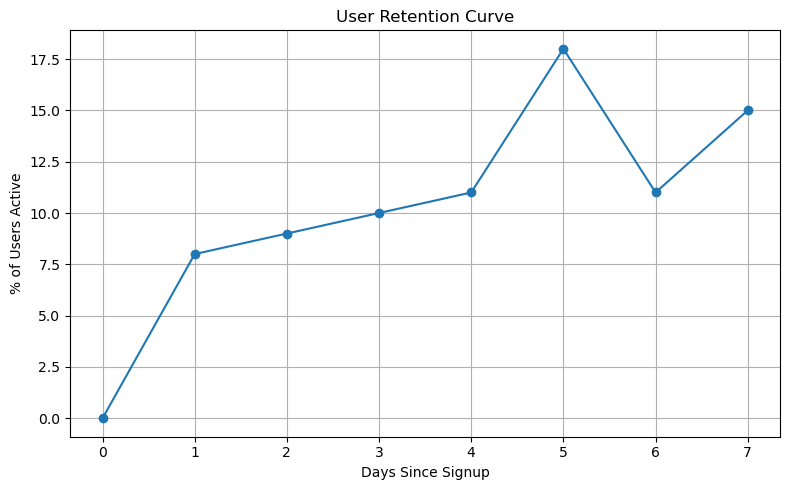

In [12]:
max_days = 7
churn = []
for day in range(max_days+1):
    active = retention[retention['days_since_signup'] == day]['user_id'].nunique()
    churn.append({'day': day, 'pct_active': active / total_users * 100})
churn_df = pd.DataFrame(churn)
plt.figure(figsize=(8,5))
plt.plot(churn_df['day'], churn_df['pct_active'], marker='o')
plt.title('User Retention Curve')
plt.xlabel('Days Since Signup')
plt.ylabel('% of Users Active')
plt.grid(True)
plt.tight_layout()
plt.show()


## Key Insights & Recommendations

- The biggest drop-off in the signup funnel is at OTP verification. Consider making this step easier or adding help text.
- Mobile users have a lower conversion rate—optimize mobile signup UX.
- Day 1 retention is X%, dropping to Y% by Day 7; target early user engagement.
- Suggest adding onboarding email on Day 1 to boost activation.

*(Fill in your numbers from the notebook for X/Y)*
ry).
